In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

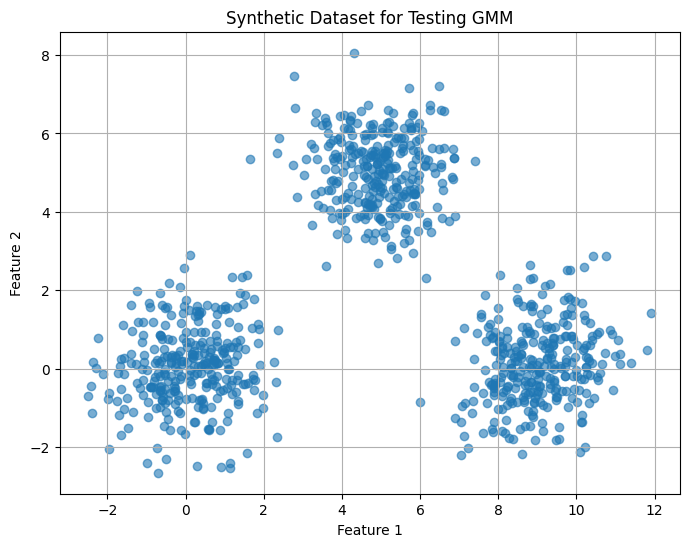

In [85]:
# Function to generate a synthetic dataset
def generate_data():
    # Set random seed for reproducibility
    np.random.seed(0)

    # Generate data for three clusters (Gaussian components)
    cluster_1 = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.1], [0.1, 1]], size=300)
    cluster_2 = np.random.multivariate_normal(mean=[5, 5], cov=[[1, -0.1], [-0.1, 1]], size=300)
    cluster_3 = np.random.multivariate_normal(mean=[9, 0], cov=[[1, 0.2], [0.2, 1]], size=300)

    # Combine the clusters to create the dataset
    data = np.vstack((cluster_1, cluster_2, cluster_3))
    return data

# Generate the dataset
data = generate_data()

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.title("Synthetic Dataset for Testing GMM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [180]:
class GMM:
    def __init__(self, n_components=3, tol=1e-4, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.means = None
        self.covariances = None
        self.weights = None
        self.responsibilities = None
    
    def multivariate_gaussian(self,x,mean,cov):
        cov_det = np.linalg.det(cov)
        cov_inv = np.linalg.inv(cov)
        norm_const = np.sqrt(np.power(2*np.pi,x.shape[1])*cov_det)
        norm_const = 1.0/norm_const
        mean_diff = x-mean
        # print(mean_diff.shape, cov_inv.shape)
        # likelihoods = norm_const*np.exp(-0.5*(mean_diff @ cov_inv).T @ mean_diff)
        likelihoods = norm_const * np.exp(-0.5 * np.sum(np.dot(mean_diff, cov_inv) * mean_diff, axis=1))
        # print(likelihoods==np.expand_dims(likelihoods_2,axis=1))
        return likelihoods
    
    def expectation(self,x):
        n_samples = x.shape[0]
        responsibilites = np.zeros(shape=(n_samples,self.n_components))
        for k in range(self.n_components):
            likelihoods = self.multivariate_gaussian(x,self.means[k],self.covariances[k])
            responsibilites[:,k] = self.weights[k]*likelihoods
        responsibilites /= np.sum(responsibilites,axis=1,keepdims=True)
        return responsibilites
    
    def maximization(self,x):
        n_samples = x.shape[0] 
        for k in range(self.n_components):
            curr_responsibilities = self.responsibilities[:,k].reshape(-1,1)
            total_curr_resp = np.sum(curr_responsibilities)
            self.means[k] = (x.T @ curr_responsibilities).T/total_curr_resp
            mean_diff = x-self.means[k] 
            # means_2 = (x * curr_responsibilities).sum(axis=0) / total_curr_resp
            # print(self.means[k]==means_2)
            
            #(n_samples,1)*(n_samples,n_features) = (n_samples,n_features).T . (n_samples,n_features)
            self.covariances[k] = np.dot((curr_responsibilities * mean_diff).T, mean_diff) / total_curr_resp
            self.weights[k] =  total_curr_resp/n_samples
            
    def expectation_maximization(self,x):
        # E-step: Compute responsibilities
        self.responsibilities = self.expectation(x)

        # M-step: Update parameters
        self.maximization(x)
    
    def fit(self,x):
        n_samples,n_features = x.shape
        np.random.seed(120)
        # initialze means to be unform distributions with shape (n_components,n_features)
        self.means = np.random.rand(self.n_components,n_features)
        
        # initialize each covariance matrix to be an identity matrix and the shape of self.covariances is (n_components,n_features,n_features) 
        self.covariances = np.array([np.eye(n_features)]*self.n_components) 
        
        # initialize weights (pie) to be of equal probabilities and sum to 1
        self.weights = np.ones(self.n_components) / self.n_components
        
        for _ in range(self.max_iter):
            old_means = self.means.copy()
            # EM-step
            self.expectation_maximization(x)
            
            # Check for convergence
            if np.linalg.norm(self.means - old_means) < self.tol:
                break
    def bic(self,x):
        likelihoods = [w*self.multivariate_gaussian(x,mean,cov) for w,mean,cov in zip(self.weights,self.means,self.covariances)]
        print(np.array(likelihoods).shape)
        log_likelihoods = np.sum(np.log(np.sum(likelihoods,axis=0)))
        n_samples,n_features = x.shape
        mean_params = self.n_components*n_features
        cov_params =  self.n_components * (n_features*(n_features+1)/2) # calculate only upper diagonal and diagonal as it is symmetric for each component
        weights_params = self.n_components-1 # no need to calculate last weight as they to 1 so it is equal to 1-sum(weights)
        params = mean_params+cov_params+weights_params
        return -2*log_likelihoods+params*np.log(n_samples)
        
    def predict(self, X):
        # Calculate responsibilities (probabilities of belonging to each component)
        responsibilities = self.expectation(X)

        # Assign each data point to the component with the highest responsibility
        return np.argmax(responsibilities, axis=1)

In [181]:
my_gmm = GMM(max_iter=1000)
my_gmm.fit(data)

In [182]:
my_gmm.means

array([[9.00756291, 0.10113662],
       [0.07998484, 0.047146  ],
       [4.92808247, 5.02007192]])

In [183]:
my_gmm.covariances

array([[[ 0.95068685,  0.20761522],
        [ 0.20761522,  1.01711346]],

       [[ 1.01160747,  0.11686898],
        [ 0.11686898,  1.00476056]],

       [[ 0.89287665, -0.06681223],
        [-0.06681223,  0.90527127]]])

In [184]:
my_gmm.predict(np.array([[2,4],[5,6]]))

array([2, 2], dtype=int64)

In [185]:
my_gmm.bic(data)

(3, 900)


7112.281551458922

In [67]:
def plot_gmm_results(data, gmm):
    """
    Plot the data, the means as points, and the covariances as ellipses.
    """
    plt.figure(figsize=(10, 8))
    
    # Plot the data points
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5, label='Data points')

    # Plot the means
    for mean in gmm.means:
        plt.scatter(mean[0], mean[1], c='red', s=100, marker='x', label='Means')
        
    plt.title("GMM Results: Means and Covariances")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage (assuming 'gmm' is a GaussianMixture object and has been fitted to 'data')
# plot_gmm_results(data, gmm)

# Note: Before running this, ensure that a GaussianMixture object 'gmm' has been created and fitted with the data.


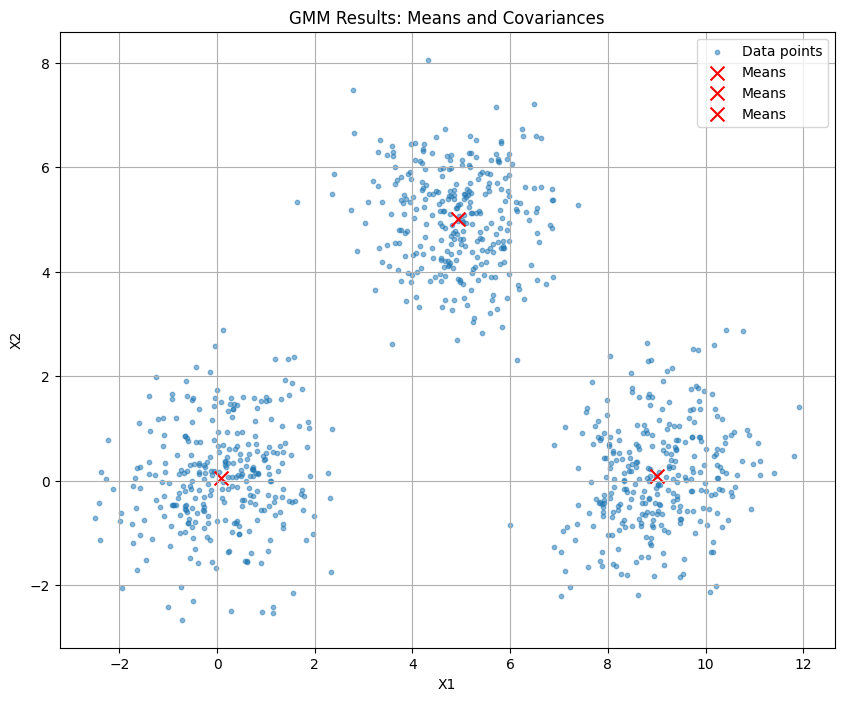

In [60]:
plot_gmm_results(data,my_gmm)


# sklearn

In [91]:
sklearn_gmm = GaussianMixture(n_components=3, tol=1e-4, max_iter=1000)
sklearn_gmm.fit(data)

GaussianMixture(max_iter=1000, n_components=3, tol=0.0001)

In [92]:
sklearn_gmm.means_

array([[9.00756293, 0.1011366 ],
       [0.07998485, 0.04714601],
       [4.9280825 , 5.0200719 ]])

In [93]:
sklearn_gmm.covariances_

array([[[ 0.95068779,  0.20761528],
        [ 0.20761528,  1.01711441]],

       [[ 1.01160849,  0.116869  ],
        [ 0.116869  ,  1.00476158]],

       [[ 0.89287769, -0.0668123 ],
        [-0.0668123 ,  0.90527234]]])

In [94]:
sklearn_gmm.predict(np.array([[2,4],[5,6]]))

array([2, 2], dtype=int64)

In [132]:
sklearn_gmm.bic(data)

7112.281551459933

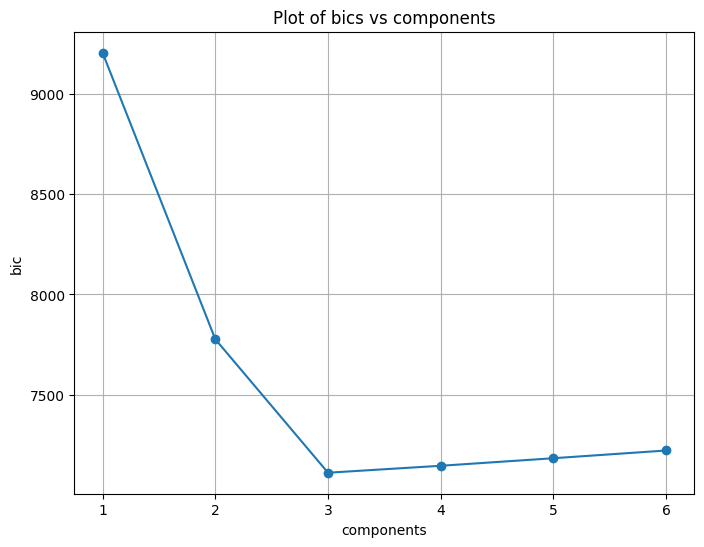

In [187]:
components = [1,2,3,4,5,6]
bics = []
for k in components:
    sklearn_gmm_temp = GaussianMixture(n_components=k, tol=1e-4, max_iter=1000)
    sklearn_gmm_temp.fit(data)
    bics.append(sklearn_gmm_temp.bic(data))

plt.figure(figsize=(8, 6))
plt.plot(components, bics, marker='o')  # 'o' marker to show the individual data points
plt.title("Plot of bics vs components")
plt.xlabel("components")
plt.ylabel("bic")
plt.grid(True)
plt.show()

3 is the best component number as it has the least bic